# 1203

https://adventofcode.com/2019/day/3

## part 1

Break this problem down in a few parts.

- Parse the wire path string into an ordered list of line segments.
- Visualize a single wire path.
- Visualize two wire paths on the same grid.
- Calculate intersections of wire A segments with wire B segments.
- Visualize intersections.
- Output the intersections in sorted order of nearest to farthest.

In [1]:
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import seaborn as sns


def manhattan_distance(pt):
    return np.abs(pt).sum()


class AASegment():
    """Convenience class for an axis aligned segment."""
    def __init__(self, p0, p1):
        self.p0 = p0
        self.p1 = p1
        if not self.is_horizontal() and not self.is_vertical():
            raise ValueError(f'The line segment ({p0[0]}, {p0[1]}), ({p1[0]}, {p1[1]}) is not axis aligned.')
    
    def __iter__(self):
        """Include support for unpacking and iterating over points in the segment."""
        return iter((self.p0, self.p1))
    
    def __repr__(self):
        return f'AASegment({self.p0}, {self.p1})'
    
    def is_horizontal(self):
        # horizontal lines have the same y
        return self.p0[1] == self.p1[1]
    
    def is_vertical(self):
        # vertical lines have the same x
        return self.p0[0] == self.p1[0]
    
    def max_x(self):
        return max(self.p0[0], self.p1[0])
    
    def min_x(self):
        return min(self.p0[0], self.p1[0])
    
    def max_y(self):
        return max(self.p0[1], self.p1[1])
    
    def min_y(self):
        return min(self.p0[1], self.p1[1])
    
    def intersections(self, other):
        """Return a tuple of intersections for the axis aligned segments..
        - If there are no intersections, this is an empty tuple.
        - If the segments are colinear and intersect in a an overlapping segment, a tuple with the two 
        points marking the extent of that segment intersection is returned.
        - If the segments are colinear and intersect in a single point, a tuple with one point is returned.
        - If the segments are perpendicular, a tuple of length 1 (a single intersection point) is returned.
        """
        def intersection_perpendicular_segments(h, v):
            # make it so that h is horizontal and v is vertical
            if h.is_vertical() and v.is_horizontal():
                h, v = v, h
            # calculate the intersection point if the segments were lines
            intersect_x = v.p0[0]
            intersect_y = h.p0[1]
            intersection_point = np.array([intersect_x, intersect_y])
            if (intersect_x >= h.min_x() and 
                intersect_x <= h.max_x() and 
                intersect_y >= v.min_y() and 
                intersect_y <= v.max_y()):
                return (intersection_point,)
            return None
        
        def intersection_horizontal_segments(h0, h1):
            """Return the intersections that could occur from two horizonal segments.
            It is possible to have zero, one, or two points of intersection.
            """
            h0_y = h0.p0[1]
            h1_y = h1.p0[1]
            if h0_y != h1_y:
                return None
            intersections = []
            if h0.min_x() >= h1.min_x() and h0.min_x() <= h1.max_x():
                # include the point belonging to `h0` at `h0.min_x()`
                intersections.extend([p for p in h0 if p[0] == h0.min_x()])
            if h0.max_x() >= h1.min_x() and h0.max_x() <= h1.max_x():
                # include the point belonging to `h0` at `h0.max_x()`
                intersections.extend([p for p in h0 if p[0] == h0.max_x()])
            if h1.min_x() >= h0.min_x() and h1.min_x() <= h0.max_x():
                # include the point belonging to `h1` at `h1.min_x()`
                intersections.extend([p for p in h1 if p[0] == h1.min_x()])
            if h1.max_x() >= h0.min_x() and h1.max_x() <= h0.max_x():
                # include the point belonging to `h1` at `h1.max_x()`
                intersections.extend([p for p in h1 if p[0] == h1.max_x()])
            return intersections
        
        def intersection_vertical_segments(v0, v1):
            """Return the intersections that could occur from two vertical segments.
            It is possible to have zero, one, or two points of intersection.
            """
            v0_x = v0.p0[0]
            v1_x = v1.p0[0]
            if v0_x != v1_x:
                return None
            intersections = []
            if v0.min_y() >= v1.min_y() and v0.min_y() <= v1.max_y():
                # include the point belonging to `v0` at `v0.min_y()`
                intersections.extend([p for p in v0 if p[1] == v0.min_y()])
            if v0.max_y() >= v1.min_y() and v0.max_y() <= v1.max_y():
                # include the point belonging to `v0` at `v0.max_y()`
                intersections.extend([p for p in v0 if p[1] == v0.max_y()])
            if v1.min_y() >= v0.min_y() and v1.min_y() <= v0.max_y():
                # include the point belonging to `v1` at `v1.min_y()`
                intersections.extend([p for p in v1 if p[1] == v1.min_y()])
            if v1.max_y() >= v0.min_y() and v1.max_y() <= v0.max_y():
                # include the point belonging to `v1` at `v1.max_y()`
                intersections.extend([p for p in v1 if p[1] == v1.max_y()])
            return intersections
        
        intersections = None
        if (self.is_horizontal() and other.is_vertical()) or (self.is_vertical() and other.is_horizontal()):
            # perpendicular axis aligned segments
            intersections = intersection_perpendicular_segments(self, other)
        elif self.is_horizontal() and other.is_horizontal() and self.p0[1] == other.p0[1]:
            # colinear horizontal segments
            intersections = intersection_horizontal_segments(self, other)
        elif self.is_vertical() and other.is_vertical() and self.p0[0] == other.p0[0]:
            # colinear vertical segments
            intersections = intersection_vertical_segments(self, other)
        # print(f'AASegment.intersections(self={self}, other={other}) => {intersections}')
        return intersections


class Wire():
    def __init__(self, wire_path_string):
        self.segments = Wire.parse_wire_path(wire_path_string)
    
    @staticmethod
    def parse_wire_path(s):
        # map the direction codes to a coordinate system
        directions = {
            'L': np.array((-1, 0)),
            'R': np.array((1, 0)),
            'U': np.array((0, 1)),
            'D': np.array((0, -1)),
        }
        current_point = np.array([0, 0])
        instructions = [i.strip() for i in s.split(',')]
        segments = []
        for instruction in instructions:
            direction = instruction[0]
            magnitude = int(instruction[1:])
            vector = magnitude * directions[direction]
            # print(f'instruction "{instruction}" to vector {vector}')
            if direction not in directions.keys():
                raise ValueError('Unhandled direction: "{direction}"')
            next_point = current_point + vector
            segments.append(AASegment(current_point, next_point))
            current_point = next_point
        return segments

    def _repr_png_(self):
        """Display the wire path as an image in Jupyter notebooks."""
        self.plot()
    
    def plot(self, ax=None, color='k'):
        if ax is None:
            fig, ax = plt.subplots(figsize=(4, 4))
        for point0, point1 in self.segments:
            xs = [point0[0], point1[0]]
            ys = [point0[1], point1[1]]
            ax.plot(xs, ys, color=color)
        ax.add_patch(Circle(self.segments[0].p0, 0.2))
        ax.set_aspect('equal')

    @staticmethod
    def get_intersections(wire_a, wire_b):
        """Return a tuple of points where this wire intersects with `other` wire.
        This algorithm makes the assumption that all line segments are axis aligned.
        """
        intersections = []
        for segment in wire_a.segments:
            for other_segment in wire_b.segments:
                inters = Wire.get_segment_intersections(segment, other_segment)
                if inters:
                    intersections.extend(inters)
        # remove the origin point
        ignore_point = np.array([0, 0])
        intersections = [i for i in intersections if not np.array_equal(i, ignore_point)]
        # sort by manhattan distance
        intersections = sorted(intersections, key=manhattan_distance)
        return intersections
    
    @staticmethod
    def get_segment_intersections(segment_a, segment_b):
        """Return a tuple of intersections for the axis aligned segments 
        `segment_a` and `segment_b`.
        - If there are no intersections, this is an empty tuple.
        - If the segments are colinear and intersect in a an overlapping segment, a tuple with the two 
        points marking the extent of that segment intersection is returned.
        - If the segments are colinear and intersect in a single point, a tuple with one point is returned.
        - If the segments are perpendicular, a tuple of length 1 (a single intersection point) is returned.
        """
        return segment_a.intersections(segment_b)        
        


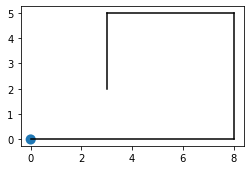

In [2]:
wire0 = Wire('R8,U5,L5,D3')
wire0

Now let's visualize two wire paths on the same grid.

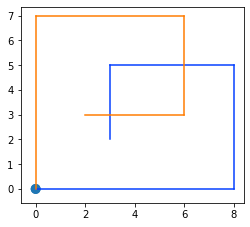

In [3]:
wire0 = Wire('R8,U5,L5,D3')
wire1 = Wire('U7,R6,D4,L4')

def plot_wires(wires):
    colors = sns.color_palette("bright", len(wires))
    fig, ax = plt.subplots(figsize=(4, 4))
    for wire, color in zip(wires, colors):
        wire.plot(ax, color)

plot_wires([wire0, wire1])

In [4]:
Wire.get_intersections(wire0, wire1)

[array([3, 3]), array([6, 5])]

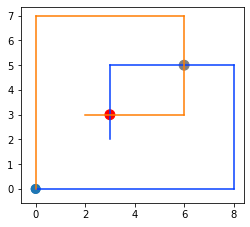

In [10]:
def plot_wires_with_intersections(wires, figsize=(4, 4), pointsize=0.2, verbose=False):
    colors = sns.color_palette("bright", len(wires))
    fig, ax = plt.subplots(figsize=figsize)
    for wire, color in zip(wires, colors):
        wire.plot(ax, color)
    for wire_a, wire_b in combinations(wires, 2):
        intersections = Wire.get_intersections(wire_a, wire_b)
        for idx, inter in enumerate(intersections):
            if verbose:
                print(f'intersection: {inter}, distance: {manhattan_distance(inter)}')
            if idx == 0:
                color = 'r'
            else:
                color = 'grey'
            ax.add_patch(Circle(inter, pointsize, color=color))
            
plot_wires_with_intersections([wire0, wire1])

In [11]:
import doctest


def get_closest_intersection(wire_a, wire_b):
    """
    >>> get_closest_intersection(Wire('R75,D30,R83,U83,L12,D49,R71,U7,L72'), Wire('U62,R66,U55,R34,D71,R55,D58,R83'))
    159
    >>> get_closest_intersection(Wire('R98,U47,R26,D63,R33,U87,L62,D20,R33,U53,R51'), Wire('U98,R91,D20,R16,D67,R40,U7,R15,U6,R7'))
    135
    """
    intersections = Wire.get_intersections(wire_a, wire_b)
    if not intersections:
        return None
    closest_intersection = intersections[0]
    return sum(closest_intersection)

doctest.run_docstring_examples(get_closest_intersection, globals(), verbose=True)

Finding tests in NoName
Trying:
    get_closest_intersection(Wire('R75,D30,R83,U83,L12,D49,R71,U7,L72'), Wire('U62,R66,U55,R34,D71,R55,D58,R83'))
Expecting:
    159
ok
Trying:
    get_closest_intersection(Wire('R98,U47,R26,D63,R33,U87,L62,D20,R33,U53,R51'), Wire('U98,R91,D20,R16,D67,R40,U7,R15,U6,R7'))
Expecting:
    135
ok


intersection: [155   4], distance: 159
intersection: [155  11], distance: 166
intersection: [158 -12], distance: 170
intersection: [146  46], distance: 192


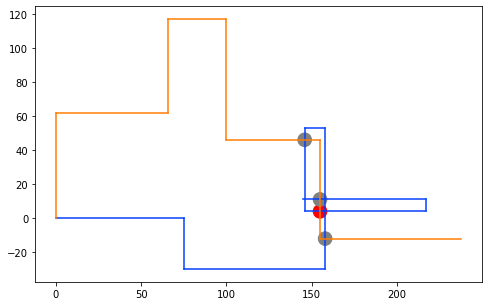

In [12]:
plot_wires_with_intersections(
    [
        Wire('R75,D30,R83,U83,L12,D49,R71,U7,L72'),
        Wire('U62,R66,U55,R34,D71,R55,D58,R83'),
    ],
    figsize=(8, 8),
    pointsize=4,
    verbose=True
)

intersection: [124  11], distance: 135
intersection: [107  47], distance: 154
intersection: [107  51], distance: 158
intersection: [157  18], distance: 175
intersection: [107  71], distance: 178


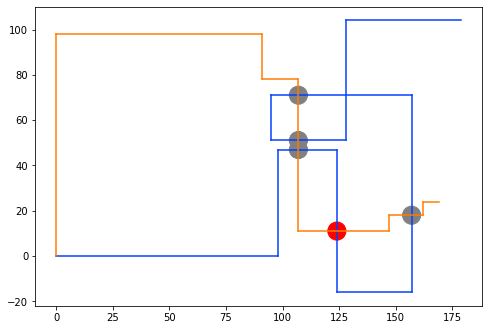

In [13]:
plot_wires_with_intersections(
    [
        Wire('R98,U47,R26,D63,R33,U87,L62,D20,R33,U53,R51'), 
        Wire('U98,R91,D20,R16,D67,R40,U7,R15,U6,R7')
    ],
    figsize=(8, 8),
    pointsize=4,
    verbose=True
)

intersection: [-361 -656], distance: 1017
intersection: [ 525 -543], distance: 1068
intersection: [ 468 -615], distance: 1083
intersection: [-315 -846], distance: 1161
intersection: [ -196 -1028], distance: 1224
intersection: [-845 -656], distance: 1501
intersection: [-877 -656], distance: 1533
intersection: [-1078  -548], distance: 1626
intersection: [  271 -1464], distance: 1735
intersection: [  372 -1877], distance: 2249
intersection: [  372 -1948], distance: 2320
intersection: [ 1261 -1081], distance: 2342
intersection: [  921 -1430], distance: 2351
intersection: [ 1296 -1081], distance: 2377
intersection: [  921 -1459], distance: 2380
intersection: [  372 -2052], distance: 2424
intersection: [ 1146 -1459], distance: 2605
intersection: [  921 -1763], distance: 2684
intersection: [ 1261 -1459], distance: 2720
intersection: [ 1296 -1459], distance: 2755
intersection: [ 1220 -1569], distance: 2789
intersection: [ 1261 -1720], distance: 2981
intersection: [ 1323 -1748], distance: 3071


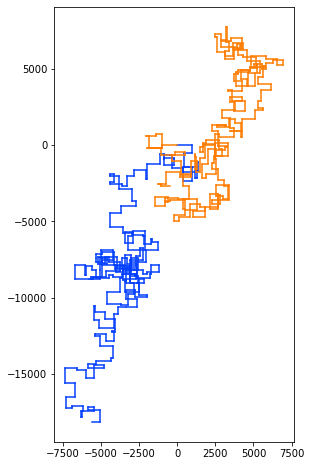

In [14]:
plot_wires_with_intersections(
    [
        Wire('R997,D543,L529,D916,R855,D705,L159,U444,R234,U639,L178,D682,L836,U333,R571,D906,L583,U872,L733,U815,L484,D641,R649,U378,L26,U66,L659,D27,R4,U325,L264,D711,L837,D986,L38,U623,L830,D369,L469,D704,L302,U143,L771,U170,R237,U477,L251,D100,R561,D889,R857,D780,R258,D299,L975,D481,L692,D894,R847,D416,R670,D658,L537,U748,R468,D304,L263,D884,R806,D13,R288,U933,R4,U291,L809,D242,R669,D50,R106,D510,R409,U311,R101,D232,R370,D490,L762,D805,L981,D637,L987,U403,R965,U724,L404,D664,L687,U868,L808,D174,L363,D241,L54,D238,R444,U75,R683,U712,L759,D569,R349,D378,L576,U437,R137,D822,R21,D595,L602,U147,R959,U350,R964,U625,L718,U331,L252,D386,L251,U371,R973,D709,R915,D837,L7,U727,L501,D520,L626,U161,L287,D224,L821,U555,L312,U234,L335,D572,L113,U673,L615,D919,R925,U16,R211,U77,R630,U786,R850,D221,R939,U559,R887,U779,L222,D482,L252,D682,L904,U568,R317,D453,R689,D917,R845,U260,R69,U613,R528,D447,L791,D119,L268,U215,L806,U786,R465,D787,L792,D823,R526,D709,L362,D748,L518,U115,L898,U784,R893,U911,R98,U215,R828,D100,R153,U496,L938,D403,R886,D317,L849,D59,R156,D27,L64,D771,R956,U880,R313,D244,L483,D17,R72,U467,L475,D444,R554,D781,R524,D152,L771,U435,L622,D601,R733,D478,L686,D12,L525,D467,L302,D948,L966,U572,L303,U914,R54,D417,R635,D425,R640,D703,R17,D187,L195,U59,R166,D616,L557,U458,L743,D166,R328,D640,R908,D775,L151,D216,L964,D202,L534,D239,R998,U167,L604,D812,L527,U526,L640,U93,L733,D980,R607,D879,L593,D721,R454,U137,R683,D343,L38,D398,L81,U392,R821,U247,L361,D208,R763,D771,L515'),
        Wire('L1000,D189,L867,U824,L193,D12,R704,U83,R371,D858,L970,D56,R877,D448,R962,U239,R641,D198,L840,D413,R586,D920,R650,U919,R375,D540,L150,U995,R54,D200,R61,D974,R249,U893,R319,U930,R658,U680,R286,D186,R963,U553,L256,U629,L554,U576,R887,U595,R629,D680,L684,U556,L302,U348,R825,D252,L684,U705,L258,D72,R907,U702,L518,U440,R239,U258,R825,U27,L580,D613,R357,D468,R519,U833,L415,D822,L798,U904,R812,U76,R86,U252,R427,U637,L896,U147,L294,U381,R306,U423,L688,D336,R648,U677,L750,D218,L649,D360,R710,D64,R317,U232,R261,D167,L49,D138,L431,D505,L535,U294,L553,U969,L144,U227,R437,D397,R359,U848,L48,D992,R169,D580,L219,D525,R552,U546,R849,D722,R894,D735,L182,U570,R274,D349,R312,U430,R441,U183,R645,D308,L416,U333,L687,U202,L973,D736,R382,U260,L176,D207,R706,U52,L142,D746,L328,D413,R879,D429,L679,D695,L224,D462,R358,D124,L515,D629,L873,D759,L763,U28,R765,D426,L93,U927,L395,U243,L393,D488,L729,U100,R488,D83,R47,U92,L871,D410,R405,D993,R537,D10,L79,D218,L686,D563,L31,U885,L784,D462,L160,U345,R204,U275,R162,U164,R843,D578,R255,D456,L398,U470,L576,D973,L337,D971,R205,U264,R707,U975,L60,U270,R1,U808,R844,D884,L952,D435,L144,D374,R389,D741,R404,D398,R282,D807,L316,U136,L504,U720,R859,D925,L711,U343,L535,D978,R578,U636,L447,D298,R574,U590,L142,D802,L846,D617,L838,U362,R812,U295,L328,U162,L617,D857,L759,D251,L343,U394,R721,U320,R836,U726,L950,D612,R129,U549,L970,D87,L341,D269,L659,U550,R835,D318,L189,U278,R871,D62,R703,U807,L389,U824,R521,D175,L698,U313,L942,D810,L498,U18,R168,D111,R607')
    ],
    figsize=(8, 8),
    pointsize=4,
    verbose=True
)

## part 2

https://adventofcode.com/2019/day/3#part2

Let's add a few methods to the existing classes.

- `Wire.distance_to_point` calculates the distance from the start of the wire along it's path to the first time a segment overlaps that point.
- `AASegment.contains_point`
- `AASegment.distance_to_point`
- `AASegment.length`


In [49]:
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import seaborn as sns


def manhattan_distance(pt):
    return np.abs(pt).sum()


class AASegment():
    """Convenience class for an axis aligned segment."""
    def __init__(self, p0, p1):
        self.p0 = p0
        self.p1 = p1
        if not self.is_horizontal() and not self.is_vertical():
            raise ValueError(f'The line segment ({p0[0]}, {p0[1]}), ({p1[0]}, {p1[1]}) is not axis aligned.')
    
    def __iter__(self):
        """Include support for unpacking and iterating over points in the segment."""
        return iter((self.p0, self.p1))
    
    def __repr__(self):
        return f'AASegment({self.p0}, {self.p1})'
    
    def is_horizontal(self):
        # horizontal lines have the same y
        return self.p0[1] == self.p1[1]
    
    def is_vertical(self):
        # vertical lines have the same x
        return self.p0[0] == self.p1[0]
    
    def max_x(self):
        return max(self.p0[0], self.p1[0])
    
    def min_x(self):
        return min(self.p0[0], self.p1[0])
    
    def max_y(self):
        return max(self.p0[1], self.p1[1])
    
    def min_y(self):
        return min(self.p0[1], self.p1[1])
    
    def intersections(self, other):
        """Return a tuple of intersections for the axis aligned segments..
        - If there are no intersections, this is an empty tuple.
        - If the segments are colinear and intersect in a an overlapping segment, a tuple with the two 
        points marking the extent of that segment intersection is returned.
        - If the segments are colinear and intersect in a single point, a tuple with one point is returned.
        - If the segments are perpendicular, a tuple of length 1 (a single intersection point) is returned.
        """
        def intersection_perpendicular_segments(h, v):
            # make it so that h is horizontal and v is vertical
            if h.is_vertical() and v.is_horizontal():
                h, v = v, h
            # calculate the intersection point if the segments were lines
            intersect_x = v.p0[0]
            intersect_y = h.p0[1]
            intersection_point = np.array([intersect_x, intersect_y])
            if (intersect_x >= h.min_x() and 
                intersect_x <= h.max_x() and 
                intersect_y >= v.min_y() and 
                intersect_y <= v.max_y()):
                return (intersection_point,)
            return None
        
        def intersection_horizontal_segments(h0, h1):
            """Return the intersections that could occur from two horizonal segments.
            It is possible to have zero, one, or two points of intersection.
            """
            h0_y = h0.p0[1]
            h1_y = h1.p0[1]
            if h0_y != h1_y:
                return None
            intersections = []
            if h0.min_x() >= h1.min_x() and h0.min_x() <= h1.max_x():
                # include the point belonging to `h0` at `h0.min_x()`
                intersections.extend([p for p in h0 if p[0] == h0.min_x()])
            if h0.max_x() >= h1.min_x() and h0.max_x() <= h1.max_x():
                # include the point belonging to `h0` at `h0.max_x()`
                intersections.extend([p for p in h0 if p[0] == h0.max_x()])
            if h1.min_x() >= h0.min_x() and h1.min_x() <= h0.max_x():
                # include the point belonging to `h1` at `h1.min_x()`
                intersections.extend([p for p in h1 if p[0] == h1.min_x()])
            if h1.max_x() >= h0.min_x() and h1.max_x() <= h0.max_x():
                # include the point belonging to `h1` at `h1.max_x()`
                intersections.extend([p for p in h1 if p[0] == h1.max_x()])
            return intersections
        
        def intersection_vertical_segments(v0, v1):
            """Return the intersections that could occur from two vertical segments.
            It is possible to have zero, one, or two points of intersection.
            """
            v0_x = v0.p0[0]
            v1_x = v1.p0[0]
            if v0_x != v1_x:
                return None
            intersections = []
            if v0.min_y() >= v1.min_y() and v0.min_y() <= v1.max_y():
                # include the point belonging to `v0` at `v0.min_y()`
                intersections.extend([p for p in v0 if p[1] == v0.min_y()])
            if v0.max_y() >= v1.min_y() and v0.max_y() <= v1.max_y():
                # include the point belonging to `v0` at `v0.max_y()`
                intersections.extend([p for p in v0 if p[1] == v0.max_y()])
            if v1.min_y() >= v0.min_y() and v1.min_y() <= v0.max_y():
                # include the point belonging to `v1` at `v1.min_y()`
                intersections.extend([p for p in v1 if p[1] == v1.min_y()])
            if v1.max_y() >= v0.min_y() and v1.max_y() <= v0.max_y():
                # include the point belonging to `v1` at `v1.max_y()`
                intersections.extend([p for p in v1 if p[1] == v1.max_y()])
            return intersections
        
        intersections = None
        if (self.is_horizontal() and other.is_vertical()) or (self.is_vertical() and other.is_horizontal()):
            # perpendicular axis aligned segments
            intersections = intersection_perpendicular_segments(self, other)
        elif self.is_horizontal() and other.is_horizontal() and self.p0[1] == other.p0[1]:
            # colinear horizontal segments
            intersections = intersection_horizontal_segments(self, other)
        elif self.is_vertical() and other.is_vertical() and self.p0[0] == other.p0[0]:
            # colinear vertical segments
            intersections = intersection_vertical_segments(self, other)
        # print(f'AASegment.intersections(self={self}, other={other}) => {intersections}')
        return intersections

    def contains_point(self, pt):
        """Returns True if the point is along this segment, False otherwise."""
        if self.is_horizontal() and self.min_y() == pt[1] and self.min_x() <= pt[0] and self.max_x() >= pt[0]:
            return True
        elif self.is_vertical() and self.min_x() == pt[0] and self.min_y() <= pt[1] and self.max_y() >= pt[1]:
            return True
        else:
            return False
    
    def distance_to_point(self, pt):
        """Returns the distance from the start of the segment to the point `pt`."""
        if self.contains_point(pt):
            return manhattan_distance(self.p0 - pt)
        return None
    
    def length(self):
        """Returns the length of this segment."""
        return manhattan_distance(self.p1 - self.p0)


class Wire():
    """
    >>> Wire('R8,U5,L5,D3').distance_to_point(np.array([2, 0]))
    2
    >>> Wire('R8,U5,L5,D3').distance_to_point(np.array([8, 4]))
    12
    >>> Wire('R8,U5,L5,D3').distance_to_point(np.array([5, 5]))
    16
    >>> Wire('R8,U5,L5,D3').distance_to_point(np.array([3, 3]))
    20
    >>> Wire('R8,U5,L5,D3').distance_to_point(np.array([3, 1])) is None
    True

    """
    def __init__(self, wire_path_string):
        self.segments = Wire.parse_wire_path(wire_path_string)
    
    @staticmethod
    def parse_wire_path(s):
        # map the direction codes to a coordinate system
        directions = {
            'L': np.array((-1, 0)),
            'R': np.array((1, 0)),
            'U': np.array((0, 1)),
            'D': np.array((0, -1)),
        }
        current_point = np.array([0, 0])
        instructions = [i.strip() for i in s.split(',')]
        segments = []
        for instruction in instructions:
            direction = instruction[0]
            magnitude = int(instruction[1:])
            vector = magnitude * directions[direction]
            # print(f'instruction "{instruction}" to vector {vector}')
            if direction not in directions.keys():
                raise ValueError('Unhandled direction: "{direction}"')
            next_point = current_point + vector
            segments.append(AASegment(current_point, next_point))
            current_point = next_point
        return segments

    def _repr_png_(self):
        """Display the wire path as an image in Jupyter notebooks."""
        self.plot()
    
    def plot(self, ax=None, color='k'):
        if ax is None:
            fig, ax = plt.subplots(figsize=(4, 4))
        for point0, point1 in self.segments:
            xs = [point0[0], point1[0]]
            ys = [point0[1], point1[1]]
            ax.plot(xs, ys, color=color)
        ax.add_patch(Circle(self.segments[0].p0, 0.2))
        ax.set_aspect('equal')

    @staticmethod
    def get_intersections(wire_a, wire_b):
        """Return a tuple of points where this wire intersects with `other` wire.
        This algorithm makes the assumption that all line segments are axis aligned.
        """
        intersections = []
        for segment in wire_a.segments:
            for other_segment in wire_b.segments:
                inters = Wire.get_segment_intersections(segment, other_segment)
                if inters:
                    intersections.extend(inters)
        # remove the origin point
        ignore_point = np.array([0, 0])
        intersections = [i for i in intersections if not np.array_equal(i, ignore_point)]
        # sort by manhattan distance
        intersections = sorted(intersections, key=manhattan_distance)
        return intersections
    
    @staticmethod
    def get_segment_intersections(segment_a, segment_b):
        """Return a tuple of intersections for the axis aligned segments 
        `segment_a` and `segment_b`.
        - If there are no intersections, this is an empty tuple.
        - If the segments are colinear and intersect in a an overlapping segment, a tuple with the two 
        points marking the extent of that segment intersection is returned.
        - If the segments are colinear and intersect in a single point, a tuple with one point is returned.
        - If the segments are perpendicular, a tuple of length 1 (a single intersection point) is returned.
        """
        return segment_a.intersections(segment_b)        
        
    def distance_to_point(self, pt):
        """Return the distance from the start of the wire following the segments until
        a segment first intersects this point.  If no segment intersects this point, `None`
        is returned.
        """
        distance = 0
        for segment in self.segments:
            if segment.contains_point(pt):
                distance += segment.distance_to_point(pt)
                return distance
            distance += segment.length()
        return None



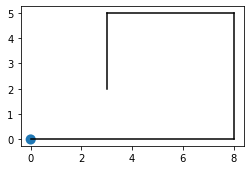

In [50]:
wire0 = Wire('R8,U5,L5,D3')
wire0

In [51]:
doctest.run_docstring_examples(Wire, globals(), verbose=True)

Finding tests in NoName
Trying:
    Wire('R8,U5,L5,D3').distance_to_point(np.array([2, 0]))
Expecting:
    2
ok
Trying:
    Wire('R8,U5,L5,D3').distance_to_point(np.array([8, 4]))
Expecting:
    12
ok
Trying:
    Wire('R8,U5,L5,D3').distance_to_point(np.array([5, 5]))
Expecting:
    16
ok
Trying:
    Wire('R8,U5,L5,D3').distance_to_point(np.array([3, 3]))
Expecting:
    20
ok
Trying:
    Wire('R8,U5,L5,D3').distance_to_point(np.array([3, 1])) is None
Expecting:
    True
ok


In [56]:
def get_minimum_steps_to_intersection(wire0, wire1):
    """Return the distance to the intersection that involves the least combined steps.
    """
    steps = []
    intersections = Wire.get_intersections(wire0, wire1)
    for intersection in intersections:
        steps.append(wire0.distance_to_point(intersection) + wire1.distance_to_point(intersection))
    return min(steps)

get_minimum_steps_to_intersection(
    Wire('R75,D30,R83,U83,L12,D49,R71,U7,L72'),
    Wire('U62,R66,U55,R34,D71,R55,D58,R83')
)

610

In [57]:
get_minimum_steps_to_intersection(
    Wire('R98,U47,R26,D63,R33,U87,L62,D20,R33,U53,R51'),
    Wire('U98,R91,D20,R16,D67,R40,U7,R15,U6,R7')
)

410

In [58]:
get_minimum_steps_to_intersection(
    Wire('R997,D543,L529,D916,R855,D705,L159,U444,R234,U639,L178,D682,L836,U333,R571,D906,L583,U872,L733,U815,L484,D641,R649,U378,L26,U66,L659,D27,R4,U325,L264,D711,L837,D986,L38,U623,L830,D369,L469,D704,L302,U143,L771,U170,R237,U477,L251,D100,R561,D889,R857,D780,R258,D299,L975,D481,L692,D894,R847,D416,R670,D658,L537,U748,R468,D304,L263,D884,R806,D13,R288,U933,R4,U291,L809,D242,R669,D50,R106,D510,R409,U311,R101,D232,R370,D490,L762,D805,L981,D637,L987,U403,R965,U724,L404,D664,L687,U868,L808,D174,L363,D241,L54,D238,R444,U75,R683,U712,L759,D569,R349,D378,L576,U437,R137,D822,R21,D595,L602,U147,R959,U350,R964,U625,L718,U331,L252,D386,L251,U371,R973,D709,R915,D837,L7,U727,L501,D520,L626,U161,L287,D224,L821,U555,L312,U234,L335,D572,L113,U673,L615,D919,R925,U16,R211,U77,R630,U786,R850,D221,R939,U559,R887,U779,L222,D482,L252,D682,L904,U568,R317,D453,R689,D917,R845,U260,R69,U613,R528,D447,L791,D119,L268,U215,L806,U786,R465,D787,L792,D823,R526,D709,L362,D748,L518,U115,L898,U784,R893,U911,R98,U215,R828,D100,R153,U496,L938,D403,R886,D317,L849,D59,R156,D27,L64,D771,R956,U880,R313,D244,L483,D17,R72,U467,L475,D444,R554,D781,R524,D152,L771,U435,L622,D601,R733,D478,L686,D12,L525,D467,L302,D948,L966,U572,L303,U914,R54,D417,R635,D425,R640,D703,R17,D187,L195,U59,R166,D616,L557,U458,L743,D166,R328,D640,R908,D775,L151,D216,L964,D202,L534,D239,R998,U167,L604,D812,L527,U526,L640,U93,L733,D980,R607,D879,L593,D721,R454,U137,R683,D343,L38,D398,L81,U392,R821,U247,L361,D208,R763,D771,L515'),
    Wire('L1000,D189,L867,U824,L193,D12,R704,U83,R371,D858,L970,D56,R877,D448,R962,U239,R641,D198,L840,D413,R586,D920,R650,U919,R375,D540,L150,U995,R54,D200,R61,D974,R249,U893,R319,U930,R658,U680,R286,D186,R963,U553,L256,U629,L554,U576,R887,U595,R629,D680,L684,U556,L302,U348,R825,D252,L684,U705,L258,D72,R907,U702,L518,U440,R239,U258,R825,U27,L580,D613,R357,D468,R519,U833,L415,D822,L798,U904,R812,U76,R86,U252,R427,U637,L896,U147,L294,U381,R306,U423,L688,D336,R648,U677,L750,D218,L649,D360,R710,D64,R317,U232,R261,D167,L49,D138,L431,D505,L535,U294,L553,U969,L144,U227,R437,D397,R359,U848,L48,D992,R169,D580,L219,D525,R552,U546,R849,D722,R894,D735,L182,U570,R274,D349,R312,U430,R441,U183,R645,D308,L416,U333,L687,U202,L973,D736,R382,U260,L176,D207,R706,U52,L142,D746,L328,D413,R879,D429,L679,D695,L224,D462,R358,D124,L515,D629,L873,D759,L763,U28,R765,D426,L93,U927,L395,U243,L393,D488,L729,U100,R488,D83,R47,U92,L871,D410,R405,D993,R537,D10,L79,D218,L686,D563,L31,U885,L784,D462,L160,U345,R204,U275,R162,U164,R843,D578,R255,D456,L398,U470,L576,D973,L337,D971,R205,U264,R707,U975,L60,U270,R1,U808,R844,D884,L952,D435,L144,D374,R389,D741,R404,D398,R282,D807,L316,U136,L504,U720,R859,D925,L711,U343,L535,D978,R578,U636,L447,D298,R574,U590,L142,D802,L846,D617,L838,U362,R812,U295,L328,U162,L617,D857,L759,D251,L343,U394,R721,U320,R836,U726,L950,D612,R129,U549,L970,D87,L341,D269,L659,U550,R835,D318,L189,U278,R871,D62,R703,U807,L389,U824,R521,D175,L698,U313,L942,D810,L498,U18,R168,D111,R607')
)

11432